In [1]:
# Imports
import os
import json
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re


# For deep learning
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops import box_iou

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


# For augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
dataset_name = "haldennord09"
darwin_root = "/home/naro/.darwin/datasets/digital-production"# "/mnt/data/darwin/digital-production"
partition_name = "2700_386_772"
dataset_version = "latest"
extension = 'png'
img_dir = os.path.join(darwin_root, dataset_name, "images")
annotations_dir = os.path.join(darwin_root, dataset_name, "releases", dataset_version, "annotations")
splits_dir  = os.path.join(darwin_root, dataset_name,"releases", dataset_version, "lists") 
partition_name = os.listdir(splits_dir)[0]

n_train, s_test, s_val = partition_name.split("_")
n_train = int(n_train)
s_test = int(s_test)
s_val = int(s_val)

print(f"Train: {n_train}, Test: {s_test}, Val: {s_val}")

train_split_file = os.path.join(darwin_root, dataset_name,"releases", dataset_version, "lists", partition_name, "random_train.txt")
test_split_file = os.path.join(darwin_root, dataset_name,"releases", dataset_version, "lists", partition_name, "random_test.txt")
val_split_file = os.path.join(darwin_root, dataset_name,"releases", dataset_version, "lists", partition_name, "random_val.txt")
#models_dir = os.path.join('/mnt/data/rumex/models', dataset_name, partition_name, dataset_version)
models_dir = '/home/naro/projects/Rumex/models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

Train: 2700, Test: 386, Val: 772


# Important remarks:

Exceptionnaly, for this dataset of birds, there are square images extracted from the high quality image dataset and there is a set of images that are extracted from the time lapse camera. 

`Image from the high quality camera are like: C2_240413_071113_0_8.jpg`

`Image from the timelapse camera ar elike: C3_AP_BF__220503_20h58.png `

I added the condition `f.count("__") > 0` to recognize the one extracted from the time lapse, but one could use both actually.


In [3]:
# File Reading and Verification
def check_directory_contents():
    # Check contents of image and annotations directories
    print("Checking directory contents...")
    print("\nFirst few images in image directory:")
    print(os.listdir(img_dir)[:5])

    print("\nFirst few annotations in annotation directory:")
    print(os.listdir(annotations_dir)[:5])

    # Read and print first few lines of split files that have been created with the darwin API
    print("\nFirst few lines in split files:")
    print("Train split:")
    with open(train_split_file, 'r') as f:
        train_annotations = [os.path.basename(line.strip()) for line in f.readlines()]
        print(train_annotations[:5])

    print("\nTest split:")
    with open(test_split_file, 'r') as f:
        test_annotations = [os.path.basename(line.strip()) for line in f.readlines() ]
        print(test_annotations[:5])

    print("\nVal split:")
    with open(val_split_file, 'r') as f:
        val_annotations = [os.path.basename(line.strip()) for line in f.readlines() ]  
        print(val_annotations[:5])

    return train_annotations, test_annotations, val_annotations

# Function to convert annotation filenames to image filenames
def get_image_files(annotation_files):
    return [f.replace('.json', f'.{extension}') for f in annotation_files]

# Run the checks
train_annotations, test_annotations, val_annotations = check_directory_contents()

# Convert to image filenames
train_images = get_image_files(train_annotations)
test_images = get_image_files(test_annotations)
val_images = get_image_files(val_annotations)

print("\nVerifying file existence...")
# Verify existence of a few files
for i in range(3):  # Check first 3 files
    if i < len(train_images):
        img_path = os.path.join(img_dir, train_images[i])
        ann_path = os.path.join(annotations_dir, train_annotations[i])
        print(f"\nChecking training pair {i+1}:")
        print(f"Image exists: {os.path.exists(img_path)} - {train_images[i]}")
        print(f"Annotation exists: {os.path.exists(ann_path)} - {train_annotations[i]}")

Checking directory contents...

First few images in image directory:
['DJI_20220901114709_0325_3_7.png', 'DJI_20220901115906_0600_8_5.png', 'DJI_20220901114344_0247_2_1.png', 'DJI_20220901114019_0169_5_3.png', 'DJI_20220901113935_0151_1_5.png']

First few annotations in annotation directory:
['DJI_20220901113924_0147_2_4.json', 'DJI_20220901114647_0315_3_6.json', 'DJI_20220901114011_0166_4_1.json', 'DJI_20220901114050_0181_6_7.json', 'DJI_20220901115158_0435_4_1.json']

First few lines in split files:
Train split:
['DJI_20220901114050_0181_3_2.json', 'DJI_20220901114249_0225_7_3.json', 'DJI_20220901114839_0359_3_0.json', 'DJI_20220901115357_0482_3_6.json', 'DJI_20220901114950_0386_2_1.json']

Test split:
['DJI_20220901115521_0514_3_5.json', 'DJI_20220901115042_0407_7_2.json', 'DJI_20220901115403_0484_3_3.json', 'DJI_20220901113319_0008_4_6.json', 'DJI_20220901113919_0145_5_5.json']

Val split:
['DJI_20220901113946_0155_2_1.json', 'DJI_20220901114205_0209_7_1.json', 'DJI_20220901115922_

In [4]:
# Checking the size of all images, add all of them to a list of tupples and get the smallest and biggest image size
image_files = os.listdir(img_dir)
def get_image_sizes(image_files):
    sizes = []
    for img_file in image_files:
        im_path = os.path.join(img_dir, img_file)
        img = Image.open(im_path)
        sizes.append(img.size)
    return sizes

# Get image sizes
train_sizes = get_image_sizes(image_files)

In [5]:
# Get the classes in the dataset

def get_classes(annotation_files):
    classes = []
    for ann_file in annotation_files:
        with open(os.path.join(annotations_dir, ann_file), 'r') as f:
            ann = json.load(f)
            for obj in ann['annotations']:
                if obj['name'] not in classes:
                    classes.append(obj['name'])
    return classes

# Get classes
annotation_files = train_annotations +  test_annotations + val_annotations

classes = get_classes(train_annotations)
print("\nClasses in the dataset:")
print(classes)
class_map = {name: idx + 1 for idx, name in enumerate(classes)}
print("\nThe created class map:")
class_map


Classes in the dataset:
['rumex_plant']

The created class map:


{'rumex_plant': 1}

In [6]:
# Get the smallest and largest image sizes
min_size = min(train_sizes)
max_size = max(train_sizes)
print(f"Smallest image size: {min_size}")
print(f"Largest image size: {max_size}")

# get and print the width and length of the smallest image
w_min = min_size[0]
h_min = min_size[1]
print(f"Width of smallest image: {w_min}")
print(f"Height of smallest image: {h_min}")


Smallest image size: (1024, 678)
Largest image size: (1024, 678)
Width of smallest image: 1024
Height of smallest image: 678


In [7]:
# Important Note II:
# The below augmentation argument is given a pascal_voc format because the way the targets are handeled in the fasterrcnn.
# According to https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html, the targets are expected to be in the format of a dictionary with the following keys
# boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H.# 
# Pascal VOC: Specifies the format of bounding boxes. Pascal VOC format means the bounding boxes are defined as (x_min, y_min, x_max, y_max).
'''
bbox_params={
        'format': 'pascal_voc', # The darwin annotations are in coco json format, bu  
        'label_fields': ['labels']
    }
'''


"\nbbox_params={\n        'format': 'pascal_voc', # The darwin annotations are in coco json format, bu  \n        'label_fields': ['labels']\n    }\n"

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from functools import partial

# Define bbox parameters explicitly
bbox_params = A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
    min_area=0,
    min_visibility=0.2,  # Adjust as needed
)

# Step 3: Define Augmentation Transformations
def get_train_transform(height=h_min, width=w_min):
    """
    Training transforms with augmentations
    """
    return A.ReplayCompose([
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
       # A.AtLeastOneBBoxRandomCrop(height=1024, width=678, p=1),
        A.Rotate(limit=45, p=0.7,border_mode=cv2.BORDER_CONSTANT),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.4, border_mode=cv2.BORDER_CONSTANT),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.1),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.1),
        A.Resize(height=height, width=width, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
        ToTensorV2(p=1.0),
    ], bbox_params=bbox_params)

def get_valid_transform(height=h_min, width=w_min):
    """
    Validation transforms without augmentations
    """
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
        A.Resize(height=height, width=width, always_apply=True),  # Resize first
        ToTensorV2(p=1.0),
    ], bbox_params=bbox_params)

# Use partial to simplify function calls
get_train_transform = partial(get_train_transform, height=h_min, width=w_min)
get_valid_transform = partial(get_valid_transform, height=h_min, width=w_min)

# Create transforms for different splits
train_transform = get_train_transform()
valid_transform = get_valid_transform()

# Print transform configurations
print("Training transforms:")
print(train_transform)
print("\nValidation transforms:")
print(valid_transform)


Training transforms:
ReplayCompose([
  HorizontalFlip(p=0.7),
  VerticalFlip(p=0.7),
  Rotate(p=0.7, limit=(-45, 45), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', crop_border=False, mask_interpolation=0),
  ShiftScaleRotate(p=0.4, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.1, 0.1), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  RandomBrightnessContrast(p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, ensure_safe_range=False),
  HueSaturationValue(p=0.1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ColorJitter(p=0.1, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)),
  Resize(p=1.0, height=678, width=1024, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406),

/home/naro/.conda/envs/rumex/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_9324/2331798127.py:27: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=height, width=width, always_apply=True),
/tmp/ipykernel_9324/2331798127.py:38: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=height, width=width, always_apply=True),  # Resize first


In [9]:
# Step 4: Data Loader Implementation

class RumexDataSet(Dataset):
    def __init__(self, img_dir, annotation_dir, images_list, annotations_list, transform=None, AugmentationVerbose = False):
        self.img_dir = img_dir  # where to find the images downloaded from darwin  
        self.annotation_dir = annotation_dir   # where to find the json annotation files downloaded from darwin    
        self.images_list = sorted(images_list) # list of image files sorted
        self.annotations_list = sorted(annotations_list)
        self.transform = transform
        self.class_map = {name: idx + 1 for idx, name in enumerate(classes)}
        self.AugmentationVerbose = AugmentationVerbose

    def __len__(self):
       # return the number of annotations in the annotation_files list
        return len(self.annotations_list)

    def __getitem__(self, idx):
        # Get image and annotation paths
        img_path = os.path.join(self.img_dir, self.images_list[idx])
        ann_path = os.path.join(self.annotation_dir, self.annotations_list[idx])

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to float32 and normalize to [0, 1]
        # image = image.astype(np.float32) / 255.0

        # Read annotation
        with open(ann_path, 'r') as f:
            annotation = json.load(f)

        # Extract bounding boxes and labels
        boxes = []
        labels = []

        for ann in annotation['annotations']:
            bbox = ann['bounding_box']
            x1 = bbox['x']
            y1 = bbox['y']
            x2 = x1 + bbox['w']
            y2 = y1 + bbox['h']

            boxes.append([x1, y1, x2, y2])
            labels.append(self.class_map[ann['name']])

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes.numpy(), labels=labels.numpy())
            if self.AugmentationVerbose:
                applied_transforms = [] 
                for trans in transformed["replay"]['transforms']:
                    if trans['applied']:  
                        applied_transforms.append(trans['__class_fullname__'] ) 
                print(applied_transforms)
            image = transformed['image']
            if len(transformed['bboxes']) > 0:
                target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
                target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)
            else:
                target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
                target['labels'] = torch.zeros((0,), dtype=torch.int64)

        return image, target

# Create datasets for each split
train_dataset = RumexDataSet(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    images_list=train_images,
    annotations_list=train_annotations,
    transform=train_transform
)

val_dataset = RumexDataSet(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    images_list=val_images,
    annotations_list=val_annotations,
    transform=valid_transform
)

test_dataset = RumexDataSet(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    images_list=test_images,
    annotations_list=test_annotations,
    transform=valid_transform
)

# Recreate data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

# Print the number of samples in each dataset
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in validation dataset: {len(val_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in training dataset: 2700
Number of samples in validation dataset: 386
Number of samples in test dataset: 772


Visualizing samples:

Sample 1:


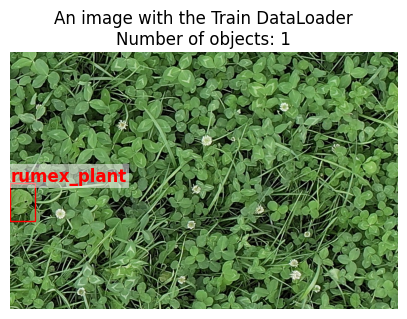


Sample 2:


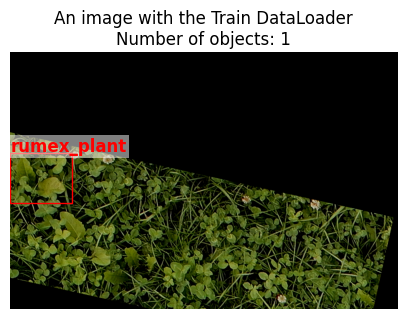


Sample 3:


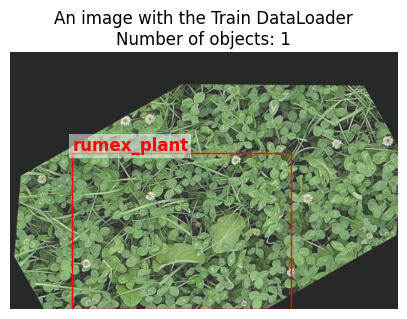

In [10]:
# Step 5: Visualization Function

def visualize_sample(dataset, idx=None, figsize=(5,5)):
    """
    Visualize a sample from the dataset with proper normalization
    """

    # Get a random sample 
    if idx is None:
        idx = np.random.randint(0, len(dataset))

    # Get image and target
    image, target = dataset[idx]


    # Convert tensor to numpy for visualization
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean  # Reverse the normalization
        image = np.clip(image, 0, 1)  # Clip values to ensure they are within [0, 1]

    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Display image
    ax.imshow(image)

    # Plot each bounding box
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    count = len(boxes)
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        class_name = classes[label - 1]
        # Create rectangle patch
        rect = plt.Rectangle((x1, y1), width, height,
                           fill=False, color='red', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, class_name, color='red', fontsize=12, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))
    title = f"An image with the Train DataLoader"
    title += f"\nNumber of objects: {len(boxes)}"
    ax.set_title(title)
    plt.axis('off')
    plt.show()

    # Print bounding box coordinates

# Visualize multiple samples
print("Visualizing samples:")
for i in range(3):  # Show 3 different samples
    print(f"\nSample {i+1}:")
    # Use validation dataset to see unaugmented images first
    visualize_sample(train_dataset)

Visualizing original image with augmentations:
{'boxes': tensor([[656., 139., 752., 201.]]), 'labels': tensor([1]), 'image_id': tensor([0])}
{'boxes': tensor([[272., 477., 368., 539.]]), 'labels': tensor([1]), 'image_id': tensor([0])}


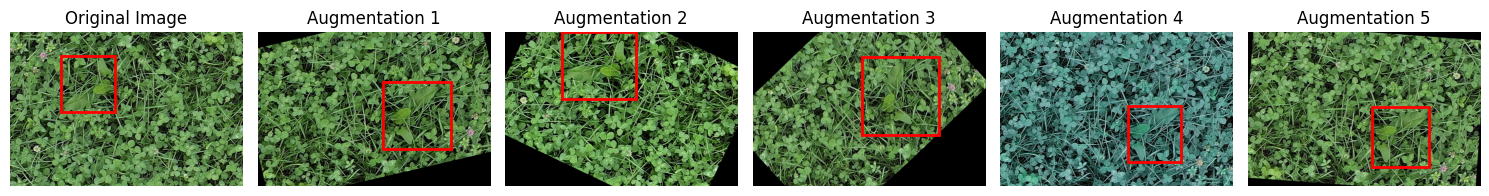


Image index: 124
Number of augmented versions shown: 5
Note: Each version may have different augmentations applied
{'boxes': tensor([[656., 139., 752., 201.]]), 'labels': tensor([1]), 'image_id': tensor([0])}
{'boxes': tensor([[272., 477., 368., 539.]]), 'labels': tensor([1]), 'image_id': tensor([0])}


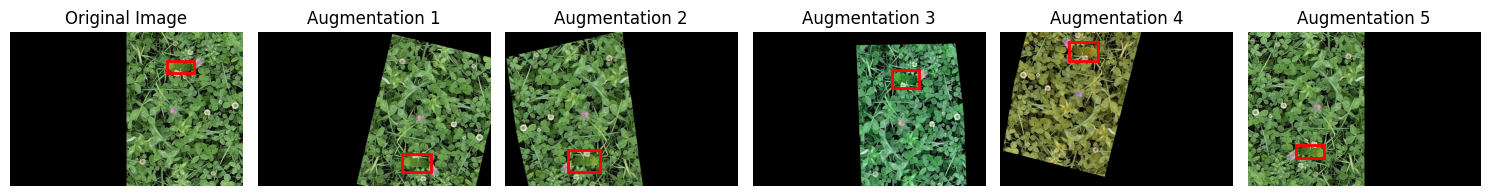


Image index: 224
Number of augmented versions shown: 5
Note: Each version may have different augmentations applied
{'boxes': tensor([[656., 139., 752., 201.]]), 'labels': tensor([1]), 'image_id': tensor([0])}
{'boxes': tensor([[222.7842, 398.0263, 333.0313, 486.1369]]), 'labels': tensor([1]), 'image_id': tensor([0])}


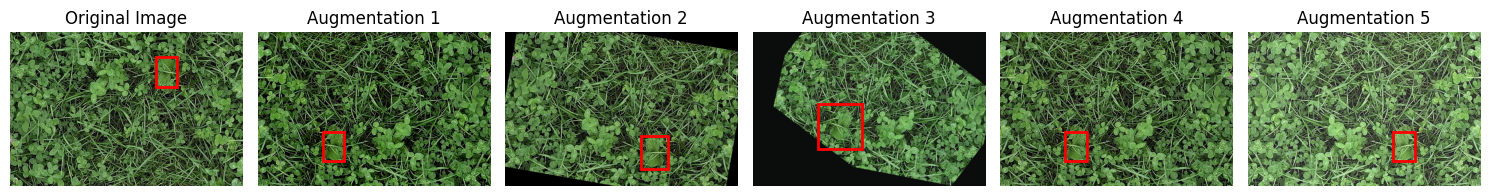


Image index: 1024
Number of augmented versions shown: 5
Note: Each version may have different augmentations applied
{'boxes': tensor([[656., 139., 752., 201.]]), 'labels': tensor([1]), 'image_id': tensor([0])}
{'boxes': tensor([[579.3144, 214.8051, 685.4762, 298.2555]]), 'labels': tensor([1]), 'image_id': tensor([0])}


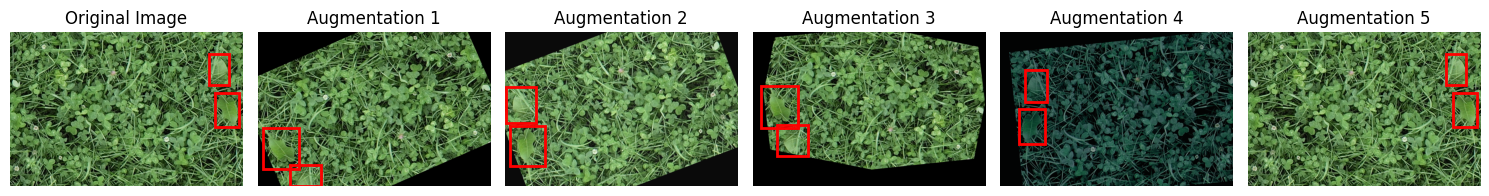


Image index: 1189
Number of augmented versions shown: 5
Note: Each version may have different augmentations applied
{'boxes': tensor([[656., 139., 752., 201.]]), 'labels': tensor([1]), 'image_id': tensor([0])}
{'boxes': tensor([[483.2153,  29.4312, 595.8934, 139.9795]]), 'labels': tensor([1]), 'image_id': tensor([0])}


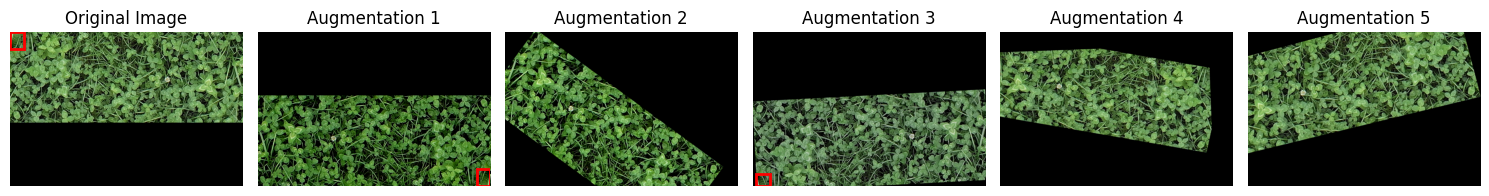


Image index: 735
Number of augmented versions shown: 5
Note: Each version may have different augmentations applied


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_augmentations(classes, idx=None, num_augmented=5, figsize=(15, 5)):
    """
    Visualize an original image side by side with its augmented versions.
    
    Args:
        dataset: Training dataset with augmentations.
        classes: List of class names (indexed from 0 or 1 based on dataset labels).
        idx: Index of the image to visualize (if None, a random image will be selected).
        num_augmented: Number of augmented versions to show.
        figsize: Figure size for matplotlib.
    """

    dataset_without_augmentation = RumexDataSet(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    images_list=train_images,
    annotations_list=train_annotations,
    transform=None
        )
    
    a, b = dataset_without_augmentation[0]
    print(b)
    dataset_with_augmentation = RumexDataSet(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    images_list=train_images,
    annotations_list=train_annotations,
    transform=train_transform
        )
    a, b = dataset_with_augmentation[0]
    print(b)

    if idx is None:
        idx = np.random.randint(0, len(dataset_without_augmentation))

    fig, axes = plt.subplots(1, num_augmented + 1, figsize=figsize)  # +1 for the original image

    # Retrieve original image & target without augmentation
    original_image, original_target = dataset_without_augmentation[idx]  # Assume dataset applies augmentation randomly
    augmented_images = [dataset_with_augmentation[idx] for _ in range(num_augmented)]  # Get multiple augmented versions
    

    # Function to process image and plot it with bounding boxes
    def plot_image(ax, image, target, title):
        # Convert tensor image to NumPy and denormalize
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean  # Reverse normalization
            image = np.clip(image, 0, 1)  # Clip to [0,1]

        ax.imshow(image)

        # Extract bounding boxes and labels
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            class_name = classes[label - 1]  # Adjust indexing if needed

            # Draw bounding box
            rect = plt.Rectangle((x1, y1), width, height, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)

            # Display class name above bounding box
            # ax.text(x1, y1 - 5, class_name, color='red', fontsize=12, fontweight='bold',
            #         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))

        ax.set_title(title)
        ax.axis('off')

    # Plot original image
    plot_image(axes[0], original_image, original_target, "Original Image")

    # Plot augmented images
    for i, (aug_image, aug_target) in enumerate(augmented_images):
        plot_image(axes[i + 1], aug_image, aug_target, f"Augmentation {i + 1}")

    plt.tight_layout()
    plt.show()

    # Print details
    print(f"\nImage index: {idx}")
    print(f"Number of augmented versions shown: {num_augmented}")
    print("Note: Each version may have different augmentations applied")

# Example usage
print("Visualizing original image with augmentations:")
for i in range(5):
    visualize_augmentations(classes=classes, num_augmented=5)


In [12]:


def init_model(num_classes, device, weights="COCO_V1", train_backbone=False):
    """
    Initialize the Faster R-CNN model and move it to the specified device.
    
    Args:
        num_classes (int): Number of classes (including background).
        device (torch.device): The device to move the model to.
        weights (str or None): Pre-trained weights.
        train_backbone (bool): Whether to train the backbone.
    
    Returns:
        model (torch.nn.Module): The initialized model.
    """

    weights = torchvision.models.detection.faster_rcnn.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Optionally freeze the backbone
    if not train_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False


    model = model.to(device)
    return model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define number of classes (update this for your dataset)
num_classes = 2  # e.g., background + bird

# Initialize model with transfer learning settings
model = init_model(num_classes, device, weights="COCO_V1", train_backbone=False)

# Print model summary
print("\nModel Overview:")
print(f"Model type: Faster R-CNN with ResNet50 backbone")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Using device: cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/naro/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 410MB/s] 



Model Overview:
Model type: Faster R-CNN with ResNet50 backbone
Number of parameters: 41299161
Number of trainable parameters: 14499865


In [14]:
def evaluate(model, val_loader, device, iou_threshold=0.5, conf_threshold=0.5):
    """
    Evaluation step
    """
    model.eval()
    total_metrics = {}

    # Initialize metrics
    map_metric = MeanAveragePrecision(box_format='xyxy' )

    total_loss = 0
    total_fp = 0
    total_fn = 0
    total_tp = 0
    total_precision = 0
    total_recall = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Calculate loss
            loss = model.loss(predictions, targets)
            total_loss += loss.item()

            # Calculate metrics for each image
            for pred, target in zip(predictions, targets):
                metrics, fp, fn, tp, precision, recall = calculate_metrics(
                    pred['boxes'],
                    pred['labels'],
                    pred['scores'],
                    target['boxes'],
                    target['labels'],
                    iou_threshold,
                    conf_threshold,
                    map_metric
                )

                # Accumulate metrics
                for k, v in metrics.items():
                    if k not in total_metrics:
                        total_metrics[k] = []
                    total_metrics[k].append(v.item())

                total_fp += fp
                total_fn += fn
                total_tp += tp
                total_precision += precision
                total_recall += recall

    avg_metrics = {k: sum(v)/len(v) for k, v in total_metrics.items()}
    avg_metrics['FP'] = total_fp / len(val_loader)
    avg_metrics['FN'] = total_fn / len(val_loader)
    avg_metrics['TP'] = total_tp / len(val_loader)
    avg_metrics['Precision'] = total_precision / len(val_loader)
    avg_metrics['Recall'] = total_recall / len(val_loader)
    avg_metrics['F1-score'] = 2 * (avg_metrics['Precision'] * avg_metrics['Recall']) / (avg_metrics['Precision'] + avg_metrics['Recall'])
    avg_metrics['Eval Loss'] = total_loss / len(val_loader)

    return avg_metrics

def calculate_metrics(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold, conf_threshold, map_metric):
    """
    Calculate detection metrics
    """
    # Filter predictions based on confidence threshold
    mask = pred_scores > conf_threshold
    pred_boxes = pred_boxes[mask]
    pred_labels = pred_labels[mask]
    pred_scores = pred_scores[mask]

    preds = [dict(
        boxes=pred_boxes,
        scores=pred_scores,
        labels=pred_labels,
    )]

    target = [dict(
        boxes=true_boxes,
        labels=true_labels,
    )]

    map_metric.update(preds, target)
    metrics = map_metric.compute()

    # Calculate TP, FP, FN
    ious = box_iou(pred_boxes, true_boxes)
    max_ious, matched_indices = ious.max(dim=1)

    tp = (max_ious > iou_threshold).sum().item()
    fp = (max_ious <= iou_threshold).sum().item()
    fn = len(true_boxes) - tp

    # Calculate Precision and Recall
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    metrics.update({
        'Precision': precision,
        'Recall': recall,
    })

    return metrics, fp, fn, tp, precision, recall


In [15]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    """
    Training for one epoch
    """

    model.train()
    total_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Move images and targets to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        loss_classifier = +loss_dict['loss_classifier']
        loss_box_reg = +loss_dict['loss_box_reg']
        loss_objectness = +loss_dict['loss_objectness']
        loss_rpn_box_reg = +loss_dict['loss_rpn_box_reg'] 

        losses = +sum(loss for loss in loss_dict.values())        
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        val_metrics = evaluate(model, val_loader, device)
        if batch_idx % 50 == 0:
            
            print(f'Epoch: {epoch},\
                  Batch: {batch_idx},\
                  loss_classifier: {loss_classifier:.4f},\
                  loss_box_reg: {loss_box_reg:.4f},\
                  loss_objectness: {loss_objectness:.4f},\
                  loss_rpn_box_reg: {loss_rpn_box_reg:.4f},\
                  Total Loss: {losses:.4f}')
    all_losses ={
    'loss_classifier': loss_classifier/len(train_loader),
    'loss_box_reg': loss_box_reg/len(train_loader),
    'loss_objectness': loss_objectness/len(train_loader),
    'loss_rpn_box_reg': loss_rpn_box_reg/len(train_loader),
    'Total Loss': losses/len(train_loader)} 

    
    return all_losses


In [ ]:
# Training time for haldennord09 is 3.5 min per epochs

lr = 0.005
num_epochs = 5
architecture = 'fastercnn-resnet50'
optimiser = 'adam'

config={
    "optimizer": optimiser,
    "learning_rate": lr,
    "architecture": architecture,
    "dataset": f'{dataset_name}:{dataset_name}',
    "epochs": num_epochs
    }

def train_model(model, train_loader, val_loader, config):
    """
    Full training loop
    """

    wandb.init(
    # set the wandb project where this run will be logged
    project="Rumex Detection",

    # track hyperparameters and run metadata
    config = config)

    wandb.define_metric("epoch")
    wandb.define_metric("map", step_metric="epoch")
    wandb.define_metric("map_50", step_metric="epoch")
    wandb.define_metric("Total Loss", step_metric="epoch")
    wandb.define_metric("Learning Rate", step_metric="epoch")
    wandb.define_metric("loss_classifier", step_metric="batch")
    wandb.define_metric("loss_box_reg", step_metric="batch")
    wandb.define_metric("loss_objectness", step_metric="batch")
    wandb.define_metric("loss_rpn_box_reg", step_metric="batch")
    wandb.define_metric("total_loss", step_metric="batch")

    # Setup optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    
   # Optimizer
    if config.get('optimizer') == 'adam':
        optimizer = torch.optim.Adam(params, lr=lr, weight_decay=0.0005)
    else:
        optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Track best model
    best_map_50 = 0
    best_model_path = os.path.join(models_dir,'best_model.pth')

    for epoch in range(num_epochs):
        # Training
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        # print(train_loss)

        # Validation
        val_metrics = evaluate(model, val_loader, device)
        print(val_metrics)

        # Update learning rate
        lr_scheduler.step()
       
        wandb.log({
            'map': val_metrics['map'],
            'map_50': val_metrics['map_50'],
            'map_75': val_metrics['map_75'],
            'Total Loss': train_loss,
            'Learning Rate': optimizer.param_groups[0]['lr'],
            'loss_classifier': train_loss['loss_classifier'],
            'loss_box_reg': train_loss['loss_box_reg'],
            'loss_objectness': train_loss['loss_objectness'],
            'loss_rpn_box_reg': train_loss['loss_rpn_box_reg'],
            'Total Loss': train_loss['Total Loss']
        })


       # Save best model
        if val_metrics['map_50'] > best_map_50:
            best_map_50 = val_metrics['map_50']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_map_50': best_map_50,
            }, best_model_path)

# Run training
train_model(model, train_loader, val_loader, config)
wandb.finish()

In [ ]:
# # Step 8: Training Loop with Metrics and W&B Logging

# def compute_iou(box1, box2):
#     x1, y1, x2, y2 = box1
#     x1g, y1g, x2g, y2g = box2

#     xi1 = max(x1, x1g)
#     yi1 = max(y1, y1g)
#     xi2 = min(x2, x2g)
#     yi2 = min(y2, y2g)
#     inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

#     box1_area = (x2 - x1) * (y2 - y1)
#     box2_area = (x2g - x1g) * (y2g - y1g)
#     union_area = box1_area + box2_area - inter_area

#     return inter_area / union_area

# def calculate_metrics_new(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold=0.5, confidence_threshold=0.5):
#     """
#     Calculate detection metrics
#     """
#     map_metric = MeanAveragePrecision(box_format='xyxy', iou_thresholds=[iou_threshold])

#     preds = [dict(
#         boxes=pred_boxes,
#         scores=pred_scores,
#         labels=pred_labels,
#     )]

#     target = [dict(
#         boxes=true_boxes,
#         labels=true_labels,
#     )]

#     map_metric.update(preds, target)
#     map_value = map_metric.compute()

#     # Filter predictions by confidence threshold
#     filtered_pred_boxes = [box for box, score in zip(pred_boxes, pred_scores) if score >= confidence_threshold]
#     filtered_pred_labels = [label for label, score in zip(pred_labels, pred_scores) if score >= confidence_threshold]

#     # Initialize counters
#     TP = 0
#     FP = 0
#     FN = 0

#     # Match predictions to ground truth
#     matched_true_boxes = set()
#     for pred_box, pred_label in zip(filtered_pred_boxes, filtered_pred_labels):
#         matched = False
#         for true_box, true_label in zip(true_boxes, true_labels):
#             if pred_label == true_label and compute_iou(pred_box, true_box) >= iou_threshold:
#                 if (true_box, true_label) not in matched_true_boxes:
#                     TP += 1
#                     matched_true_boxes.add((true_box, true_label))
#                     matched = True
#                     break
#         if not matched:
#             FP += 1

#     # Calculate FN
#     FN = len(true_boxes) - TP

#     # Calculate precision, recall, and F1 score
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     metrics = {
#         'map_50': map_value['map'].item(),
#         'TP': TP,
#         'FP': FP,
#         'FN': FN,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1_score
#     }

#     return metrics


# def calculate_metrics(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels):
#     """
#     Calculate detection metrics 
#     """
#     map = MeanAveragePrecision(box_format='xyxy')

#     preds = [dict(
#         boxes=pred_boxes,
#         scores=pred_scores,
#         labels=pred_labels,
#     )]

#     target = [dict(
#         boxes=true_boxes,
#         labels=true_labels,
#     )]

#     map.update(preds, target)
#     metrics = map.compute()

#     return metrics


# def evaluate(model, val_loader, device):

#     """
#     Evaluation step
#     """
#     model.eval()
#     total_metrics = {}
#     total_metrics_new = {}

#     with torch.no_grad():
#         for images, targets in val_loader:
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             # Get predictions
#             predictions = model(images)

#             # Calculate metrics for each image
#             for pred, target in zip(predictions, targets):
#                 metrics = calculate_metrics(
#                     pred['boxes'],
#                     pred['labels'],
#                     pred['scores'],
#                     target['boxes'],
#                     target['labels']
#                 )

#                 # Accumulate metrics
#                 for k, v in metrics.items():
#                     if k not in total_metrics:
#                         total_metrics[k] = []
#                     total_metrics[k].append(v.item())

#     avg_metrics = {k: sum(v)/len(v) for k, v in total_metrics.items()}


#     return avg_metrics

In [ ]:
# Step 9: Inference and Visualization

def load_best_model(model, best_model_path)
    """
    Load the best model from checkpoint
    """
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with mAP@50: {checkpoint['best_map_50']:.4f}")
    return model

def predict_and_visualize(model, test_dataset, idx=None, confidence_threshold=0.5, figsize=(12,12)):
    """
    Make prediction on a single image and visualize results
    """
    model.eval()

    # Select random index if none provided
    if idx is None:
        idx = np.random.randint(0, len(test_dataset))

    # Get image and target
    image, target = test_dataset[idx]

    # Prepare image for model
    image_tensor = image.unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        prediction = model(image_tensor)

    # Convert image for visualization
    # image_np = image.permute(1, 2, 0).cpu().numpy()
    # image_np = (image_np * 255).astype(np.uint8)

    # Assuming `image` is a PyTorch tensor
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # ImageNet mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = (image_np * std + mean) * 255
    image_np = np.clip(image_np, 0, 255).astype(np.uint8)

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot ground truth
    ax1.imshow(image_np)
    boxes = target['boxes'].cpu().numpy()
    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height,
                           fill=False, color='green', linewidth=2)
        ax1.add_patch(rect)
    ax1.set_title('Ground Truth')
    ax1.axis('off')

    # Plot prediction
    ax2.imshow(image_np)
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()

    for box, score in zip(pred_boxes, pred_scores):
        if score > confidence_threshold:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height,
                               fill=False, color='red', linewidth=2)
            ax2.add_patch(rect)
            ax2.text(x1, y1-5, f'{score:.2f}', color='red')
    ax2.set_title('Prediction')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nGround Truth:")
    print(f"Number of birds: {len(boxes)}")
    print(f"\nPredictions (confidence > {confidence_threshold}):")
    print(f"Number of detections: {len(pred_scores[pred_scores > confidence_threshold])}")
    print("\nPrediction scores:", pred_scores[pred_scores > confidence_threshold])

# Load best model
best_model_path = os.path.join(models_dir, 'best_model.pth')
model = load_best_model(model)

# Make predictions on multiple test samples
print("Visualizing predictions on test samples:")
for i in range(3):  # Show 3 random samples
    print(f"\nTest Sample {i+1}:")
    predict_and_visualize(model, test_dataset, confidence_threshold=0.5)



In [ ]:
# Step 10: Ray Tune Hyperparameter Optimization

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
from ray.train import Checkpoint
import os

def train_with_parameters(config):
    """
    Training function for ray tune with memory optimization
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create model
    model = get_model()
    model = model.to(device)

    # Create optimizer with tuned parameters
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"]
    )

    # Reduce batch size for tuning
    tune_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # Train for a few epochs
    for epoch in range(2):
        model.train()
        total_loss = 0
        batch_loss = 0  # Initialize batch_loss

        for batch_idx, (images, targets) in enumerate(tune_loader):
            try:
                # Clear cache before each batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()
                loss_dict = model(images, targets)
                batch_loss = sum(loss for loss in loss_dict.values())  # Store in batch_loss

                batch_loss.backward()
                optimizer.step()

                total_loss += batch_loss.item()

                if batch_idx % 10 == 0:
                    print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {batch_loss.item():.4f}")

                # Clear memory
                del images, targets, loss_dict
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        # Calculate average loss
        avg_loss = total_loss / len(tune_loader)

        # Save checkpoint
        checkpoint_dir = f"/tmp/checkpoint_epoch_{epoch}"
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "loss": avg_loss
        }, f"{checkpoint_dir}/checkpoint.pth")

        # Report metrics
        session.report(
            metrics={
                "training_loss": avg_loss,
                "epoch": epoch
            },
            checkpoint=Checkpoint.from_directory(checkpoint_dir)
        )

def run_hyperparameter_tuning():
    """
    Configure and run ray tune
    """
    device = "gpu" if torch.cuda.is_available() else "cpu"
    resources = {"cpu": 2, "gpu": 1} if device == "gpu" else {"cpu": 2}

    config = {
        "lr": tune.loguniform(1e-4, 1e-2),
        "momentum": tune.uniform(0.8, 0.99),
        "weight_decay": tune.loguniform(1e-5, 1e-3)
    }

    scheduler = ASHAScheduler(
        time_attr='training_iteration',
        max_t=2,
        grace_period=1,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            train_with_parameters,
            resources=resources
        ),
        tune_config=tune.TuneConfig(
            metric="training_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=5
        ),
        param_space=config,
        run_config=ray.air.RunConfig(
            storage_path="/content/ray_results",
            name="rumex_detection_tuning"
        )
    )

    print(f"Using device: {device.upper()}")
    results = tuner.fit()

    best_result = results.get_best_result(metric="training_loss", mode="min")
    print(f"\nBest trial config: {best_result.config}")
    print(f"Best trial final loss: {best_result.metrics['training_loss']}")

    return best_result.config

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

# Run hyperparameter tuning
print("Starting hyperparameter tuning...")
try:
    best_config = run_hyperparameter_tuning()

    # Save best configuration
    print("\nSaving best configuration...")
    import json
    with open('best_hyperparameters.json', 'w') as f:
        json.dump(best_config, f)
except Exception as e:
    print(f"Error during tuning: {str(e)}")
finally:
    ray.shutdown()